- Convert HydroBASIN polygons from SHP to KML
- Fix geometry errors 
- Simplify geometry (optionally)

In [1]:
%matplotlib inline

import logging
import sys
import os
import glob

import math
import ogr
import shapely.geometry, shapely.wkt
import pylab
import matplotlib.pyplot as plt
from utils.shapely_plot import draw
import shapely as sl
import fiona
import numpy as np
import networkx as nx

pylab.rcParams['figure.figsize'] = (17.0, 15.0)
logging.basicConfig(stream=sys.stderr, level=logging.INFO)


In [18]:
info = {
    'sa' : { 
        'name': 'South America',
        'main_basin_id': 6010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_sa_lev*_v1c.shp'),
        'pfaf_ids': range(61, 68)
    },
    'af' : { 
        'name': 'Africa',
        'main_basin_id': 1010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_af_lev*_v1c.shp'),
        'pfaf_ids': range(11, 19)
    },
    'si' : { 
        'name': 'Siberia',
        'main_basin_id': 3010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_si_lev*_v1c.shp'),
        'pfaf_ids': range(31, 37)
    },
    'eu' : { 
        'name': 'Europe and Middle East',
        'main_basin_id': 2010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_eu_lev*_v1c.shp'),
        'pfaf_ids': range(21, 30)
    },
    'na' : { 
        'name': 'North America and Carribean',
        'main_basin_id': 7010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_na_lev*_v1c.shp'),
        'pfaf_ids': range(71, 79)
    },
    'ar' : { 
        'name': 'North American Arctic',
        'main_basin_id': 8010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_ar_lev*_v1c.shp'),
        'pfaf_ids': range(81, 87)
    },
    'ar2' : { 
        'name': 'North American Arctic 2',
        'main_basin_id': 8010020760,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_ar_lev*_v1c.shp'),
        'pfaf_ids': [3]
    },
    'as' : { 
        'name': 'Central and South-East Asia',
        'main_basin_id': 4010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_as_lev*_v1c.shp'),
        'pfaf_ids': range(41, 50)
    },
    'au' : { 
        'name': 'Australia and Oceania',
        'main_basin_id': 5010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_au_lev*_v1c.shp'),
        'pfaf_ids': range(51, 58)
    },
    'gr' : { 
        'name': 'Greenland',
        'main_basin_id': 9010000010,
        'files': glob.glob(r'D:\gis\HydroBASINS\without_lakes\hybas_gr_lev*_v1c.shp'),
        'pfaf_ids': [91]
    },
}

# max_w = 4.0
# max_h = 4.0
# base_dir = '../output/basins_max_4/'

max_w = 12.0
max_h = 12.0
base_dir = '../output/basins_max_12/'

In [19]:
def get_basin(id, path):
    with fiona.collection(path, "r") as input:
        for f in input:
            if id == f['properties']['HYBAS_ID']:
                return f
    return None

def get_child_basins(parent_pfaf_id, child_basins_path):
    with fiona.collection(child_basins_path, "r") as input:
        for feature in input:
            pfaf_id = feature['properties']['PFAF_ID'] 
            if str(pfaf_id).startswith(str(parent_pfaf_id)): 
                yield feature

def get_children(main_basin_id, child_basins_path):
    print('Child basins: ' + child_basins_path)
    child_basins = list(get_child_basins(main_basin_id, child_basins_path))
    child_basins_ids = [str(f['properties']['PFAF_ID']) for f in child_basins]
    child_basins_geoms = [sl.geometry.shape(f['geometry']) for f in child_basins]
    count = len(child_basins)
    print(count)
    
    return (child_basins, child_basins_ids, child_basins_geoms)

def convert_basins_to_graph(region):
    n = nx.DiGraph()

    main_basin_id = region['main_basin_id']
    files = region['files']
    pfaf_ids = region['pfaf_ids']
    name = region['name']

    main_basin = get_basin(main_basin_id, files[0])

    pfaf_id = str(main_basin['properties']['PFAF_ID'])
    main_basin_geom = sl.geometry.shape(main_basin['geometry'])

    print('Main basin: ' + files[0])
    print('Main basin pfafid: ' + pfaf_id)
    print('Area: ' + str(main_basin_geom.area))

    basins2, ids2, geoms2 = get_children(pfaf_id, files[0])
    basins3, ids3, geoms3 = get_children(pfaf_id, files[1])
    basins4, ids4, geoms4 = get_children(pfaf_id, files[2])
    basins5, ids5, geoms5 = get_children(pfaf_id, files[3])
    basins6, ids6, geoms6 = get_children(pfaf_id, files[4])
    basins7, ids7, geoms7 = get_children(pfaf_id, files[5])
    basins8, ids8, geoms8 = get_children(pfaf_id, files[6])
    basins9, ids9, geoms9 = get_children(pfaf_id, files[7])

    basins_per_level = [basins2, basins3, basins4, basins5, basins6, basins7, basins8, basins9]

    ids = [pfaf_id]+ids2+ids3+ids4+ids5+ids6+ids7+ids8+ids9
    areas = [g.area for g in [main_basin_geom]+geoms2+geoms3+geoms4+geoms5+geoms6+geoms7+geoms8+geoms9]
    basins = [b for b in [main_basin]+basins2+basins3+basins4+basins5+basins6+basins7+basins8+basins9]

    print('Total basins: {0}'.format(len(basins)))
    
    n.add_nodes_from([(i,{'area':a, 'feature':f}) for (i,a,f) in zip(ids, areas, basins)])
    # n.add_nodes_from([(i,{'area':a}) for (i,a,f) in zip(ids, areas, basins)])

    n.add_edges_from([(pfaf_id, i) for i in ids2])
    n.add_edges_from([(i[:-1], i) for i in ids3])
    n.add_edges_from([(i[:-1], i) for i in ids4])
    n.add_edges_from([(i[:-1], i) for i in ids5])
    n.add_edges_from([(i[:-1], i) for i in ids6])
    n.add_edges_from([(i[:-1], i) for i in ids7])
    n.add_edges_from([(i[:-1], i) for i in ids8])
    n.add_edges_from([(i[:-1], i) for i in ids9])

    # max_level = 6
    # n = n.subgraph([kv[0] for kv in list(n.degree().iteritems()) if len(kv[0]) < max_level + 2])
    
    return n

def get_wh(geom):
    bounds = geom.bounds

    w = bounds[2]-bounds[0]
    h = bounds[3]-bounds[1]
    
    return (w, h) 

def geometry_larger_than(geom, w, h):
    bounds = geom.bounds
    gw = bounds[2]-bounds[0]
    gh = bounds[3]-bounds[1]
    return (gw > w) or (gh > h)

def geometry_smaller_than(geom, w, h):
    bounds = geom.bounds
    gw = bounds[2]-bounds[0]
    gh = bounds[3]-bounds[1]
    return (gw < w) and (gh < h)

def get_leaves_smaller_than(graph, graph_nodes, node, w, h):
    for child_node in graph.successors(node):
        geom = sl.geometry.shape(graph_nodes[child_node]['feature']['geometry'])
        
        last = len(graph.successors(child_node)) == 0
    
        if(geometry_smaller_than(geom, w, h) or last):
            yield child_node
        else:
            for child_child_node in get_leaves_smaller_than(graph, graph_nodes, child_node, w, h):
                yield child_child_node

                
def get_leaf_basins(graph, graph_nodes, pfaf_id, max_w, max_h):
    """Returns leaf basins smaller than max_w, max_h"""
    leaves = list(get_leaves_smaller_than(graph, graph_nodes, str(pfaf_id), max_w, max_h))
    print(len(leaves))
    s = graph.subgraph(leaves)
    return s                

def write_basins(region_id, info, pfaf_id, basins, file_name=None, mode='w'):
    with fiona.open(info['files'][0]) as source:
        source_driver = source.driver
        source_crs = source.crs
        source_schema = source.schema

    # strange bug? values are not written unless we add .1
    source_schema['properties']['HYBAS_ID'] = 'float:11.1'
    source_schema['properties']['NEXT_DOWN'] = 'float:11.1'
    source_schema['properties']['NEXT_SINK'] = 'float:11.1'
    source_schema['properties']['MAIN_BAS'] = 'float:11.1'

    if not file_name:
        file_name = base_dir  + '/hybas_' + region_id + '_PFAF' + str(pfaf_id) + '_v1c.shp'
    print('Writing ' + file_name)
    
    with fiona.open(file_name, mode, driver=source_driver, crs=source_crs, schema=source_schema) as c:
        for node in basins:
            feature = node[1]['feature']

            geom = sl.geometry.shape(feature['geometry'])
            if not geom.is_valid:
                clean = geom.buffer(0.0) # Use the 0-buffer polygon cleaning trick
                assert clean.is_valid
                geom = clean
                feature['geometry'] = sl.geometry.mapping(geom)
                
            c.write(feature)


In [20]:
first = True
for i in list(info.iteritems()):
    region_id = i[0]
    region_info = i[1]
    
    print('Region: ' + region_id)
    
    graph = convert_basins_to_graph(region_info)
    graph_nodes=dict(graph.nodes(data=True))

    for pfaf_id in region_info['pfaf_ids']:
        basins = get_leaf_basins(graph, graph_nodes, pfaf_id, max_w, max_h).nodes(data=True)
        if first:
            mode = 'w'
        else:
            mode = 'a'
        # write_basins(region_id, region_info, pfaf_id, basins, base_dir + 'all.shp', mode)
        write_basins(region_id, region_info, pfaf_id, basins)
        first=False

Region: sa
Main basin: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev01_v1c.shp
Main basin pfafid: 6
Area: 1548.56753183
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev01_v1c.shp
1
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev02_v1c.shp
7
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev03_v1c.shp
31
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev04_v1c.shp
147
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev05_v1c.shp
496
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev06_v1c.shp
1946
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev07_v1c.shp
7036
Child basins: D:\gis\HydroBASINS\without_lakes\hybas_sa_lev08_v1c.shp
23783
Total basins: 33448
30


Writing ../output/basins_max_12//hybas_sa_PFAF61_v1c.shp
77


Writing ../output/basins_max_12//hybas_sa_PFAF62_v1c.shp
21


Writing ../output/basins_max_12//hybas_sa_PFAF63_v1c.shp
29


Writing ../output/basins_max_12//hybas_sa_PFAF64_v1c.shp
22


Writing ../output/basins_max_12//hybas_sa_PFAF65_v1c.shp
25


Writing ../output/basins_max_12//hybas_sa_PFAF66_v1c.shp
20


Writing ../output/basins_max_12//hybas_sa_PFAF67_v1c.shp


Level: 1, Feature Count: 0
Level: 2, Feature Count: 0
Level: 3, Feature Count: 0
Level: 4, Feature Count: 0
Level: 5, Feature Count: 0
Level: 6, Feature Count: 0
Level: 7, Feature Count: 0
Level: 8, Feature Count: 0
Level: 9, Feature Count: 0
Level: 10, Feature Count: 0


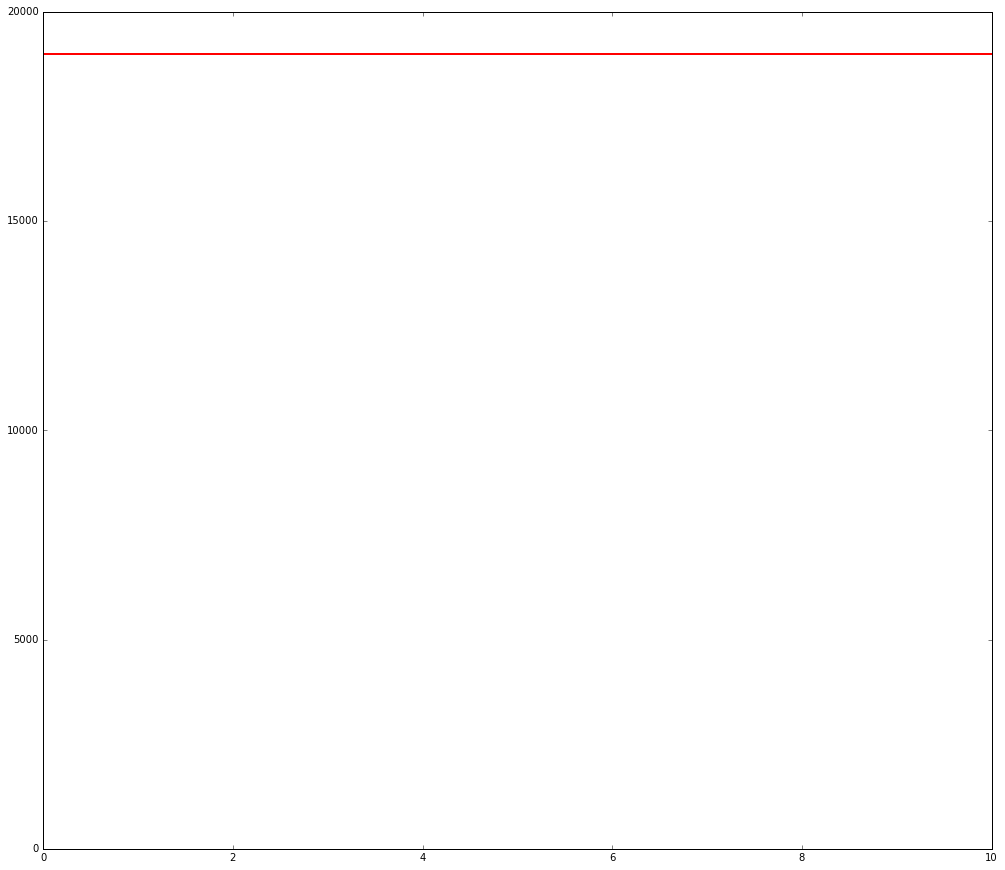

In [9]:
# count total number of catchments for levels 2-10

levels = range(1, 11)
count = []
for level in levels:
    files = glob.glob(r'..\shared\HydroBASINS\without_lakes\hybas_*_lev{0:02}_v1c.shp'.format(level))

    feature_count = 0
    for f in files:
        with fiona.open(f) as source:
            feature_count += len(source)
    count.append(feature_count)
        
    print('Level: {0}, Feature Count: {1}'.format(level, feature_count))

plt.plot(levels, count)
plt.plot([0, 10], [19000, 19000], 'r-', lw=2)


In [5]:
# test
n = convert_basins_to_graph(info['gr'])
nodes=dict(n.nodes(data=True))

shape=sl.geometry.shape(nodes[nodes.keys()[0]]['feature']['geometry'])
shape   

IndexError: list index out of range

In [ ]:
(w, h) = get_wh(shape)

print('w', w)
print('h', h)

In [ ]:
basins_wh = []
basins_wh_min = []
basins_wh_max = []
basins_count = []


for basins in basins_per_level:
    whs = [get_wh(sl.geometry.shape(basin['geometry'])) for basin in basins]
    max_wh = np.max([max(whi) for whi in whs])
    min_wh = np.min([min(whi) for whi in whs])
    count = len(basins)
    wh = 0.5*(max_wh+min_wh)
    basins_wh_min.append(min_wh)
    basins_wh_max.append(max_wh)
    basins_wh.append(wh)
    basins_count.append(count)
    print(min_wh, wh, max_wh, count)

In [ ]:
# show number of catchments per level + maximum Width / Height
min_wh_values = []
max_wh_values = []
wh_values = []
average_wh_values = []
catchment_count = []
for i in np.arange(0.2, 9.0, 0.2):
    selection = list(get_leaves_smaller_than('61', i, i))
    
    wh = [get_wh(sl.geometry.shape(nodes[basin]['feature']['geometry'])) for basin in selection]
    max_wh = np.max([max(whi) for whi in wh])
    min_wh = np.min([min(whi) for whi in wh])
    average_wh_values.append(0.5*(min_wh+max_wh))
    count = len(basins)

    count = len(selection)
    print(min_wh, i, max_wh, count)
    catchment_count.append(count)
    max_wh_values.append(max_wh)
    min_wh_values.append(min_wh)
    
    wh_values.append(i)

In [ ]:
plt.plot(catchment_count, wh_values, 'ob-', linewidth=2.0)
plt.plot(catchment_count, average_wh_values, 'b-')
plt.plot(catchment_count, min_wh_values, 'b--')
plt.plot(catchment_count, max_wh_values, 'b--')


# plt.errorbar(wh_values, catchment_count,xerr=[min_error_wh_values, max_error_wh_values], fmt='.')


# plt.errorbar(wh_values, catchment_count, xerr=error_wh_values)

plt.plot(basins_count, basins_wh, 'or-', linewidth=2.0)
plt.plot(basins_count, basins_wh_min, 'r--')
plt.plot(basins_count, basins_wh_max, 'r--')

# plt.errorbar(basins_wh, basins_count, xerr=[basins_wh_error_min,basins_wh_error_max])


In [ ]:
large_nodes = list((node for (node, data) in n.nodes(data=True) 
                    if geometry_larger_than(sl.geometry.shape(data['feature']['geometry']), max_w, max_h)))
s = n.subgraph(large_nodes)
print(len(large_nodes))
leaves=[node for node,data in s.out_degree().items() if data==0]
print(len(list(leaves)))
s = n.subgraph(leaves)


Try to open it in http://visjs.org/examples/network/15_dot_language_playground.html

In [ ]:
nx.write_dot(n, r"..\output\catchment_pfafids.dot")
print(len(n.nodes()))

In [ ]:
pos = nx.spring_layout(nx.Graph(n), iterations=500)

In [1]:
import math

node_areas=[data['area'] for node,data in n.nodes(data=True)]

node_sizes=[math.log(a)*100 for a in node_areas]

nx.draw_networkx_nodes(n, pos, node_color=node_areas, node_size=node_sizes, cmap=plt.cm.Blues, alpha=0.85)
_ = nx.draw_networkx_edges(n, pos, alpha=0.2)
# _ = nx.draw_networkx_labels(n, pos, font_size=15)

# nx.draw_networkx_nodes(s, pos, node_size=20, cmap=plt.cm.Reds, alpha=0.85)


NameError: name 'n' is not defined

In [ ]:
leaf_basins = list(s.nodes(data=True))

fig = plt.figure()
axes = plt.axes()
axes.set_aspect('equal', 'datalim')

for f in leaf_basins:
    geom = sl.geometry.shape(f[1]['feature']['geometry'])
    draw(geom, alpha=0.5)

plt.show()  


In [ ]:
print(n.predecessors('5642'))
print(n.successors('5642'))

s = n.subgraph(n.successors('5642')+['5642','564','56424','5648','56480'])

node_areas=[data['area'] for node,data in s.nodes(data=True)]
node_sizes=[a*5 for a in node_areas]

pos = nx.spring_layout(nx.Graph(s), iterations=500, scale=10.0)

nx.draw_networkx_nodes(s, pos, node_color=node_areas, node_size=node_sizes, cmap=plt.cm.Blues, alpha=0.85)
_ = nx.draw_networkx_edges(s, pos, alpha=0.2)
_ = nx.draw_networkx_labels(s, pos, font_size=15)    

Select basins where Area + Width/Height ratio are just less than a given parameter

In [ ]:
def get_catchments_using_area(graph, root, max_area):
    children = graph.successors(root)
    for child in children:
        graph[child]
    
print(n.predecessors('5642'))
print(n.successors('5642'))
